## Neural Network Project: Constructing a CNN Auto-Encoder for Traffic Data Imputation

#### 1. Installing packages

In [ ]:
pip install tensorflow tensorflow-datasets

#### 2. Importing libraries

In [53]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, UpSampling2D, Conv2DTranspose

In [52]:
## Building the image data set
(train_ds, val_ds) = tf.keras.utils.image_dataset_from_directory('Image_Data', labels = None, color_mode = 'grayscale', batch_size = 32, seed = 365,
                                                   image_size = (200, 200), shuffle = True, validation_split = 0.25, subset = 'both')

## Scaling the data to be between 0 and 1
train_ds = train_ds.map(lambda x:(x/255))
val_ds = val_ds.map(lambda x:(x/255))

Found 512 files belonging to 1 classes.
Using 384 files for training.
Using 128 files for validation.


#### 3. Loading images from directory into tf.Dataset

In [54]:
## Building the image data set
train_ds = tf.keras.utils.image_dataset_from_directory('Image_Data', labels = None, color_mode = 'grayscale', batch_size = None, 
                                                       seed = 365, image_size = (200, 200), shuffle = True)

Found 512 files belonging to 1 classes.


#### 4. Image data preprocessing

In [55]:
## Scaling the data to be between 0 and 1
train_ds = train_ds.map(lambda x:(x/255))

In [57]:
## Converting tf.Dataset objects to numpy arrays
def dataset_to_numpy(ds):
    images = []
    for i, image in enumerate(tfds.as_numpy(ds)): 
        images.append(image)
    return np.array(images)

train = dataset_to_numpy(train_ds)[0:384]
val = dataset_to_numpy(train_ds)[384:512]

In [ ]:
#data_iterator = train_ds.as_numpy_iterator()
#batch = data_iterator.next()
batch = train.next()
fig, ax = plt.subplots(ncols=4, figsize=(14,14))
for idx, img in enumerate(batch[:4]):
    ax[idx].imshow(img, cmap = 'gray')

In [ ]:
train = tfds.as_numpy(train_ds)
val = tfds.as_numpy(val_ds)

In [ ]:
## Defining a numpy iterator to look through data batches
data_interator = train_ds.as_numpy_iterator()

## Splitting the data into training, validation, and testing
train_size = 3050
val_size = 1000
#test_size = 

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
#test = data.skip(train_size + val_size).take(test_size)

In [ ]:
## Defining a numpy iterator to look through data batches
data_interator = train_ds.as_numpy_iterator()

## Grabbing the first batch from the data set
batch = data_interator.next()

## Visualizing some images from the first batch
fig, axs = plt.subplots(ncols = 4, figsize = (14, 14))
for i, img in enumerate(batch[:4]):
    axs[i].imshow(batch[i], cmap = 'gray')

#### 5. Constructing the auto-encoder architecture

In [58]:
## Defining the Sequential model
autoencoder = Sequential(name = 'Autoencoder')

## Input Layer
autoencoder.add(Input(shape=(200, 200, 1), name = 'Input'))

## Convo-Pooling Layer 1
autoencoder.add(Conv2D(20, (9,9), 1, activation = 'relu', data_format = 'channels_last', name = 'Conv_1'))
autoencoder.add(MaxPooling2D(pool_size = (4,4), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_1'))

## Convo-Pooling Layer 2
autoencoder.add(Conv2D(60, (9,9), 1, activation = 'relu',  data_format = 'channels_last', name = 'Conv_2'))
autoencoder.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_2'))

## Convo-Pooling Layer 3
autoencoder.add(Conv2D(180, (9,9), 1, activation = 'relu',  data_format = 'channels_last', name = 'Conv_3'))
autoencoder.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_3'))

## Fully-Connected Layer
autoencoder.add(Dense(180, activation = 'relu', use_bias = False, name = 'Dense'))

## Up Convo-Pooling Layer 1
autoencoder.add(UpSampling2D(size = (2,2), data_format = 'channels_last', name = 'Up_Max_1'))
autoencoder.add(Conv2DTranspose(180, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_1'))

##Up Convo-Pooling Layer 2
autoencoder.add(UpSampling2D(size = (2,2), data_format = 'channels_last', name = 'Up_Max_2'))
autoencoder.add(Conv2DTranspose(60, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_2'))

## Up Convo-Pooling Layer 3
autoencoder.add(UpSampling2D(size = (4,4), data_format = 'channels_last', name = 'Up_Max_3'))
autoencoder.add(Conv2DTranspose(20, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_3'))

## Output Layer
autoencoder.add(Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same',  data_format = 'channels_last', name = 'Output'))

In [59]:
## Compiling the Sequential model
autoencoder.compile(optimizer = 'adam', loss = tf.losses.MeanSquaredError())

## Printing a model summary
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 192, 192, 20)      1640      
                                                                 
 Max_1 (MaxPooling2D)        (None, 48, 48, 20)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 40, 40, 60)        97260     
                                                                 
 Max_2 (MaxPooling2D)        (None, 20, 20, 60)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 12, 12, 180)       874980    
                                                                 
 Max_3 (MaxPooling2D)        (None, 6, 6, 180)         0         
                                                                 
 Dense (Dense)               (None, 6, 6, 180)         

#### 6. Fitting the autoencoder model

In [60]:
autoencoder.fit(train, train, epochs = 1, batch_size = None, shuffle = True, validation_data = (val, val))

12/12 [==============================] - 83s 7s/step - loss: 0.0273 - val_loss: 0.0070


#### 7. Predicting on the testing data

In [61]:
decoded_val_images = autoencoder.predict(val)

4/4 [==============================] - 13s 3s/step


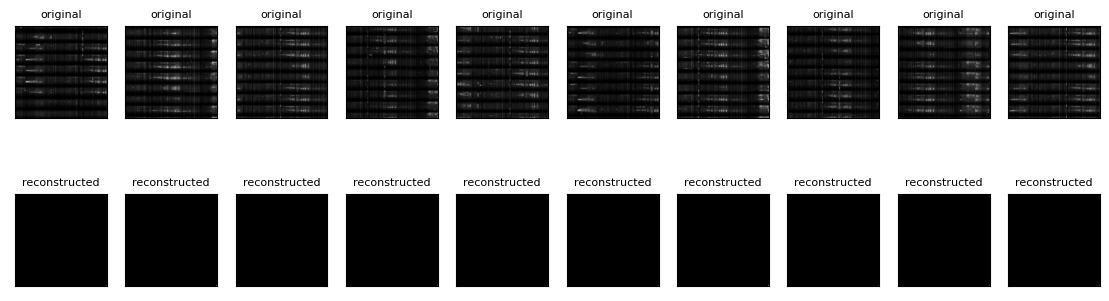

In [70]:
n = 10
plt.figure(figsize=(14, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(val[i]), cmap = 'gray')
    plt.title("original", fontsize = 8)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(decoded_val_images_new[i]), cmap = 'gray')
    plt.title("reconstructed", fontsize = 8)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [68]:
decoded_val_images_new = decoded_val_images*255

In [71]:
decoded_val_images_new.max()

21.696924